In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
target_dir = "C:\\Volcano\\quail_volcano\\scenarios\\entrainment\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"

# Path for Quail source code
source_dir = "C:\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [4]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphaseWLMA.multiphaseWLMA as multiphaseWLMA
import physics.multiphaseWLMA.iapws95_light.mixtureWLMA as mixtureWLMA

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

from types import SimpleNamespace

os.chdir(target_dir)

In [5]:
# Default physics backend construction
wlma = mixtureWLMA.WLMA(c_v_m0=1e3)

# Manual import of water methods
import sys
sys.path.append(r"C:\Volcano\quail_volcano\src\physics\multiphaseWLMA\iapws95_light")
import float_mix_functions

import scipy.optimize
import scipy.integrate

In [ ]:
# Initial
rhow = 996
T = 600
e = float_mix_functions.u(rhow, T)

# Cache initial guess
rhow_last = rhow
p_end = 1e5

def e_rhs(T, e):
  ''' (de/drho)_s '''
  rhow = rhow_calc(T, e)
  return float(float_mix_functions.p(rhow, T) / (rhow*rhow))

def rhow_calc(T, e):
  global rhow_last
  energy_mismatch = lambda rhow: float_mix_functions.u(rhow, float(np.array(T))) / float(np.array(e)) - 1.0
  rhow_guesses = [rhow_last, 0.3, 0.2, 0.1, 0.01]
  for rhow_guess in rhow_guesses:
    solve_out = scipy.optimize.fsolve(energy_mismatch, rhow_guess, full_output=True, xtol=1e-6)
    if solve_out[2] == 1:
      break
  else:
    print(f"rhow not solved: T = {T}, rhow_last = {rhow_last}")
    print(solve_out[1])
  rhow = solve_out[0]
  rhow_last = rhow
  return rhow

def term_event(T, e):
  rhow = rhow_calc(T, e)
  p = float(float_mix_functions.p(rhow, T))
  return p / p_end - 1.0
term_event.direction = -1
term_event.terminal = True

soln = scipy.integrate.solve_ivp(e_rhs, [600, 300], [e], events=term_event, max_step=10)
T_vec = soln.t
e_vec = soln.y[0,:]
# Post-process
rhow_vec = np.array([rhow_calc(T, e) for T, e in zip(T_vec, e_vec)]).flatten()
p_vec = np.array([float(float_mix_functions.p(rhow, T)) for rhow, T in zip(rhow_vec, T_vec)])

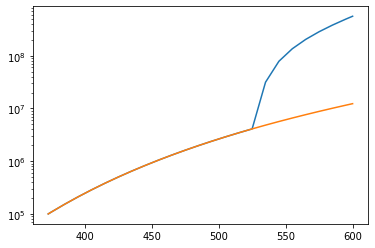

In [83]:
_triples_vec = [float_mix_functions.prho_sat(T) for T in T_vec]
psat_vec, rho_satl_vec, rho_satv_vec = zip(*[(t["psat"], t["rho_satl"], t["rho_satv"]) for t in _triples_vec])
psat_vec = np.array(psat_vec)
rho_satl_vec = np.array(rho_satl_vec)
rho_satv_vec = np.array(rho_satv_vec)
plt.semilogy(T_vec, p_vec)
plt.semilogy(T_vec, psat_vec)

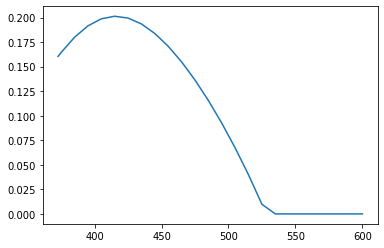

In [87]:
steamfrac_vec = (1/rhow_vec - 1/rho_satl_vec) / (1/rho_satv_vec - 1/rho_satl_vec)
steamfrac_vec = np.clip(steamfrac_vec, 0, 1)
plt.plot(T_vec, steamfrac_vec)

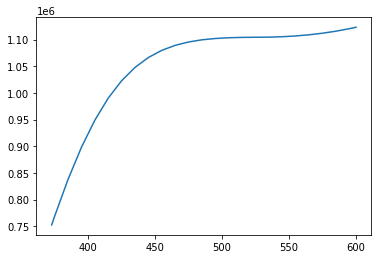

In [88]:
plt.plot(T_vec, e_vec)


In [202]:
# Pull critical values
R = wlma.R
Tc = 647.096
pc = 22.064e6
rhoc = 322.

In [203]:
# Entropy calculation for single-phase fluid

def steam_frac(rho, T):
  # Compute saturation
  if T >= Tc:
    x = np.nan
  else:
    _triple = float_mix_functions.prho_sat(T)
    v_l = 1.0 / _triple["rho_satl"]
    v_v = 1.0 / _triple["rho_satv"]
    v = 1.0 / rho
    x = np.clip((v - v_l)/(v_v - v_l), 0.0, 1.0)
  return x

def nondim_entropy(rho, T):
  ''' Postprocess for entropy '''
  d = rho / rhoc
  t = Tc / T
  # Compute saturation
  if T >= Tc:
    x = 0
  else:
    _triple = float_mix_functions.prho_sat(T)
    v_l = 1.0 / _triple["rho_satl"]
    v_v = 1.0 / _triple["rho_satv"]
    v = 1.0 / rho
    x = np.clip((v - v_l)/(v_v - v_l), 0.0, 1.0)

  def pure_entropy(d, t):
    ''' Nondimensional entropy s/R for pure phase. '''
    return t * (float_mix_functions.phi0_t(d, t)
                + float_mix_functions.phir_t(d, t)) \
           - (float_mix_functions.phi0(d, t) + float_mix_functions.phir(d, t))

  # Compute phase-equilibrium entropy
  if x <= 0 or x >= 1:
    s = pure_entropy (d, t)
  else:
    s = (x * pure_entropy (1 / (v_v*rhoc), t)
            + (1.0 - x) * pure_entropy (1 / (v_l*rhoc), t))
  return s

s_vec = [nondim_entropy(rho, T) for rho, T in zip(rhow_vec, T_vec)]

In [264]:
''' Compute entropy as function of rho, T and then
associate values of s with each (rho, T) on uniform grid in (s, T) space'''
# Grid s(T, rho)
rho_in = np.geomspace(0.0001, 1020, 480)
T_vec = np.linspace(0.02+273.15, 1000, 640)
s_vec = np.linspace(0.2, 25, 200)
mg_s, mg_T = np.meshgrid(s_vec, T_vec)
mg_rho = mg_s.copy()
mg_e = mg_s.copy()
mg_p = mg_s.copy()
mg_x = mg_s.copy()

for i in range(mg_T.shape[0]):
  T = T_vec[i]
  # Compute s for rho in rho_in
  s_out = np.array([nondim_entropy(rho, T) for rho in rho_in])
  # Re-interpolate rho to uniform s grid
  rho_out = np.interp(s_vec, s_out[::-1], rho_in[::-1])
  # Save values of rho on uniform s grid
  mg_rho[i,:] = rho_out
  # Postprocess quantities on uniform s grid
  mg_e[i,:] = np.array([float_mix_functions.u(rho, T) for rho in rho_out])
  mg_p[i,:] = np.array([float_mix_functions.p(rho, T) for rho in rho_out])
  mg_x[i,:] = np.array([steam_frac(rho, T) for rho in rho_out])

In [259]:
s_out[-1]

9.04234397125714

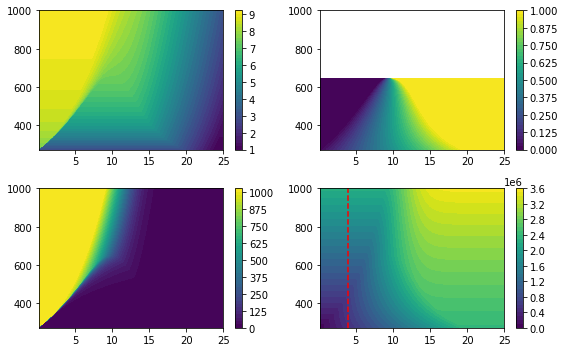

In [265]:
plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
plt.contourf(mg_s, mg_T, np.log10(mg_p), levels=40)
plt.colorbar()

plt.subplot(2,2,2)
plt.contourf(mg_s, mg_T, mg_x, levels=40)
plt.colorbar()

plt.subplot(2,2,3)
plt.contourf(mg_s, mg_T, mg_rho, levels=40)
plt.colorbar()

plt.subplot(2,2,4)
plt.contourf(mg_s, mg_T, mg_e, levels=40)
plt.colorbar()
plt.plot(mg_s[:,30], mg_T[:,30], 'r--')

plt.tight_layout()

Text(0, 0.5, 'Steam fraction')

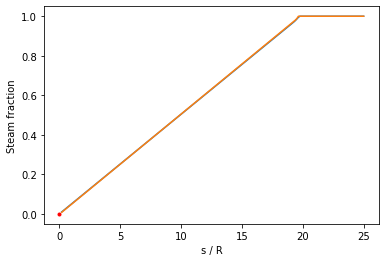

In [ ]:
# Triple-point temperature steam fraction

# Triple point calculations
rho = 1000 - 0.03
T = 273.15+0.0101
nondim_entropy(rho, T), float_mix_functions.p(rho, T)


plt.plot(mg_s[0,:], mg_x[0,:])
plt.plot(mg_s[1,:], mg_x[1,:])
plt.plot([0.0], [0.0], '.r', label="Triple point")
plt.xlabel("s / R")
plt.ylabel("Steam fraction")


In [308]:
(mg_e[287,:] - mg_e[:287,:]).max()

1128960.9452009494

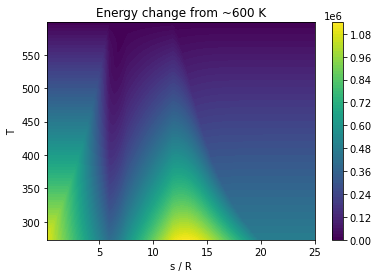

In [ ]:
plt.title("Energy change from ~600 K")
# for j in range(mg_T.shape[1]):
#   plt.plot(mg_T[:,j], mg_e[:,j])
mg_de = np.clip(mg_e[287:288,:] - mg_e, 0, None)
plt.contourf(mg_s[:287,:],
             mg_T[:287,:],
             mg_de[:287,:], levels=100)
plt.xlabel("s / R")
plt.ylabel("T")
plt.colorbar()

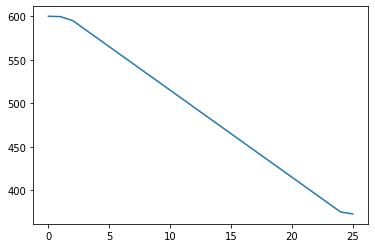

In [144]:
plt.plot(T_vec)


In [121]:
rho * R * T * (1 + d * float_mix_functions.phir_d(d, t)) / pc  -1

1.0036416142611415e-13